<a href="https://colab.research.google.com/github/NaokiDohi/senior_thesis/blob/master/J_diff_QRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## improt

In [ ]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

from google.colab import files

## load model

In [ ]:
#load_model('model.h5')

#load and reshape data

In [ ]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？

Dude!! This file is already download


In [ ]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20,8/26/20,8/27/20,8/28/20,8/29/20,8/30/20,8/31/20,9/1/20,9/2/20,9/3/20,9/4/20,9/5/20,9/6/20,9/7/20,9/8/20,9/9/20,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
151,NaN,Japan,36.204824,138.252924,2,2,2,2,4,4,7,7,11,15,20,20,20,22,23,23,23,24,24,26,27,28,33,43,54,60,67,79,85,95,112,137,149,160,173,192,...,52471,53818,55051,56074,56717,57636,58728,59900,60949,61916,62658,63158,63888,64779,65653,66499,67353,67958,68396,69023,69619,70278,70866,71467,71918,72213,72724,73264,73916,74558,75206,75646,75914,76446,76997,77488,78061,78662,79142,79462


In [ ]:
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

2020-01-22        2
2020-01-23        2
2020-01-24        2
2020-01-25        2
2020-01-26        4
              ...  
2020-09-17    77488
2020-09-18    78061
2020-09-19    78662
2020-09-20    79142
2020-09-21    79462
Name: 151, Length: 244, dtype: int64


#元データのプロットと画像保存

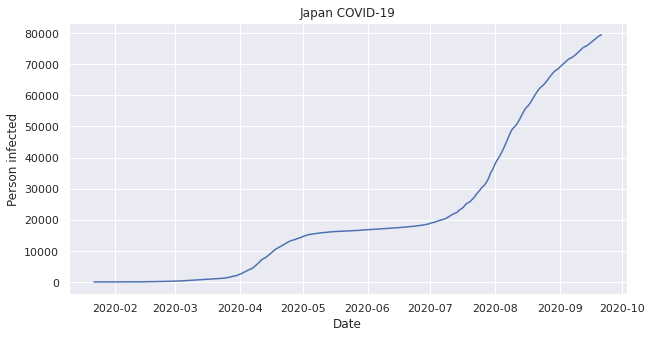

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date")
plt.ylabel("Person infected")
plt.grid(True)
plt.show()

In [ ]:
#ファイル保存
fname ='original.png'
plt.savefig(fname) 
plt.close() 

# residual diff

In [ ]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff

2020-01-22      NaN
2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
              ...  
2020-09-17    491.0
2020-09-18    573.0
2020-09-19    601.0
2020-09-20    480.0
2020-09-21    320.0
Name: 151, Length: 244, dtype: float64

In [ ]:
data_at_japan_diff = data_at_japan_diff.dropna()

In [ ]:
data_at_japan_diff

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-09-17    491.0
2020-09-18    573.0
2020-09-19    601.0
2020-09-20    480.0
2020-09-21    320.0
Name: 151, Length: 243, dtype: float64

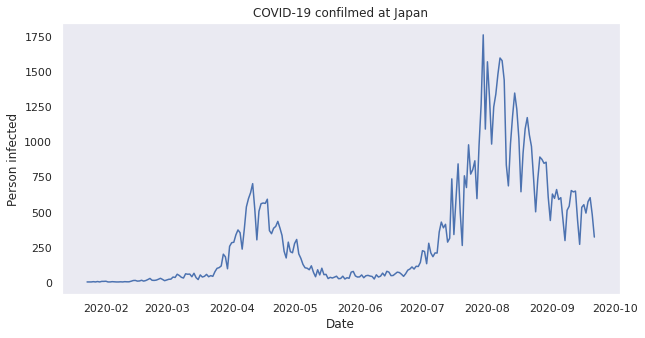

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel('Date')
plt.ylabel('Person infected')
plt.grid()
plt.show()

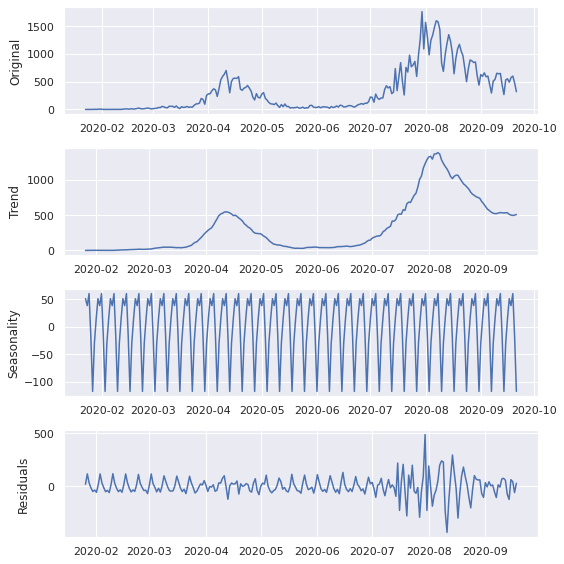

In [ ]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [ ]:
y = data_at_japan_diff.values.astype(float)

In [ ]:
test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

In [ ]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

In [ ]:
from sklearn.preprocessing import  MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

In [ ]:
window = 7#学習時のウィンドウサイズ

In [ ]:
study_data, correct_data  = sequence_creator(train_normalized, window)

# QRNN class

In [ ]:
from __future__ import absolute_import
import numpy as np

from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec

from keras.utils.conv_utils import conv_output_length

import theano
import theano.tensor as T


def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x


class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.recurrent_dropout = 0 #not used, added to maintain compatibility with keras.Bidirectional
        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
n_out = 1
n_hidden = 300

model = Sequential()
model.add(QRNN(64,window_size=7,dropout=0.2))
model.add(Dense(n_out))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer,metrics=["acc"])# optimizer="rmsprop"
#print(model.summary())

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
epochs=100#200
history = model.fit(study_data, correct_data, batch_size=31, epochs=epochs, validation_split=0.1, callbacks=[early_stopping], verbose=0)#32

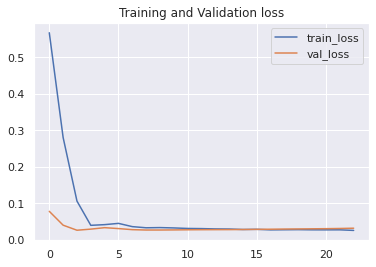

In [ ]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
#plt.ylim((0, 0.1))#add
plt.legend()
plt.show()

In [ ]:
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

In [ ]:
datetime = dt.datetime.now()
today = f'{datetime.year}-{datetime.month}-{datetime.day}'
today = pd.to_datetime(today)
print(today)

2020-09-23 00:00:00


In [ ]:
the_week_before_last = f'{datetime.year}-{datetime.month}-{datetime.day-16}'
the_week_before_last= pd.to_datetime(the_week_before_last)
the_week_before_last

Timestamp('2020-09-07 00:00:00')

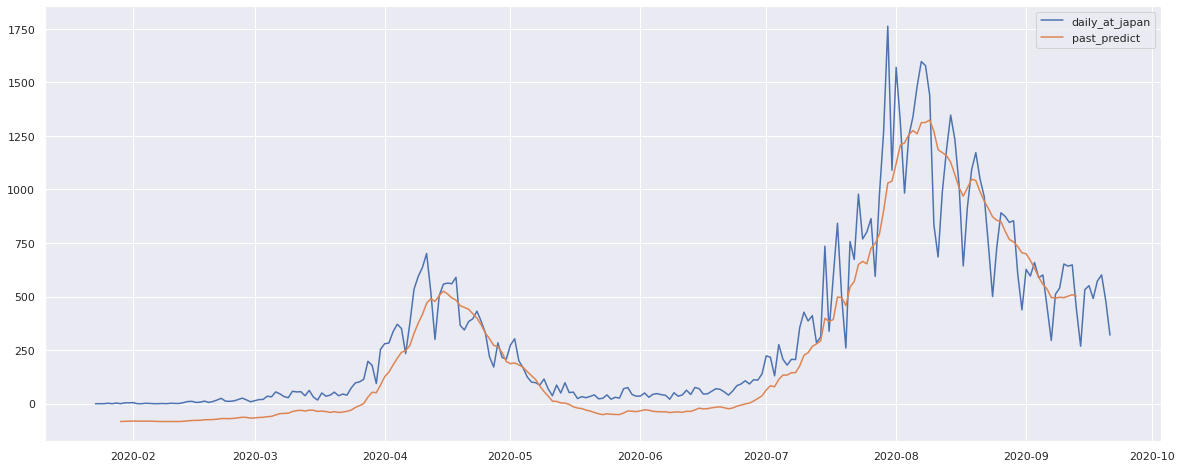

In [ ]:
plt.figure(figsize=(20,8))#サンプル数が多いので通常のpltでは表示がおかしくなるので適当な引数を渡して拡大表示
x0 = np.arange('2020-01-22',the_week_before_last, dtype='datetime64[D]').astype('datetime64[D]')
plt.plot(data_at_japan_diff, label='daily_at_japan')
plt.plot(x0+7,train_inverse,label='past_predict')
plt.legend()

In [ ]:
upcoming_future=7

In [ ]:
#初期データの作成
predictions = train_normalized[-window:].tolist()
print("predictions:" + str(predictions))
print("____________________________________________________________________________")
#Kerasの入力形状を生成
predictions = np.array(predictions).reshape(-1, window, 1)
print("predictions:")
print("   ")
print(predictions)
print("   ")
#predicted_future = predictions
#print(predicted_future)

predictions:[[-0.41997729852440413], [-0.3870601589103292], [-0.2599318955732123], [-0.2712826333711691], [-0.264472190692395], [-0.5005675368898979], [-0.695800227014756]]
____________________________________________________________________________
predictions:
   
[[[-0.4199773 ]
  [-0.38706016]
  [-0.2599319 ]
  [-0.27128263]
  [-0.26447219]
  [-0.50056754]
  [-0.69580023]]]
   


In [ ]:
#予測をfor文で
for i in range(upcoming_future):
  print(str(i+1) + "回目のforループ")
  predicted_future = model.predict(predictions)
  print("predicted_future:" + str(predicted_future) + "    " + "row_predicted_future:"+ str(scaler.inverse_transform(np.array(predicted_future).reshape(-1,1))))
  print("____________________________________________________________________________")
  predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  print("predictions:" + str(predictions))
  print("____________________________________________________________________________")
  predictions = predictions[-window:]
  print("predictions:" + str(predictions))
  print("____________________________________________________________________________")
  predictions = np.array(predictions).reshape(-1, window, 1)
  print("predictions:")
  print("   ")
  print(predictions)
  print("   ")
  if(i != window-1):
    print("____________________________________________________________________________")

1回目のforループ
predicted_future:[[-0.45778418]]    row_predicted_future:[[477.69214]]
____________________________________________________________________________
predictions:[-0.4199773  -0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754
 -0.69580023 -0.45778418]
____________________________________________________________________________
predictions:[-0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754 -0.69580023
 -0.45778418]
____________________________________________________________________________
predictions:
   
[[[-0.38706016]
  [-0.2599319 ]
  [-0.27128263]
  [-0.26447219]
  [-0.50056754]
  [-0.69580023]
  [-0.45778418]]]
   
____________________________________________________________________________
2回目のforループ
predicted_future:[[-0.44660434]]    row_predicted_future:[[487.54153]]
____________________________________________________________________________
predictions:[-0.38706016 -0.2599319  -0.27128263 -0.26447219 -0.50056754 -0.69580023
 -0.45778418 -0.44660

In [ ]:
predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
predictions_infected_pepole

array([[477.69214106],
       [487.54157534],
       [490.61957443],
       [457.40493149],
       [424.42895418],
       [394.54449773],
       [392.75526685]])

In [ ]:
lastweek = f'{datetime.year}-{datetime.month}-{datetime.day-7}'
lastweek= pd.to_datetime(lastweek)
lastweek

Timestamp('2020-09-16 00:00:00')

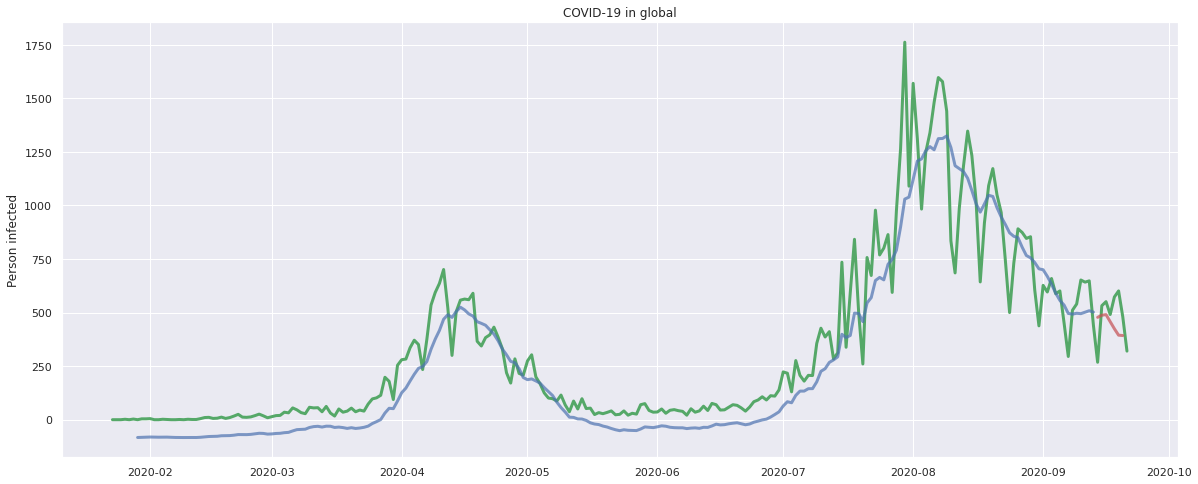

In [ ]:
x = np.arange(lastweek, today, dtype='datetime64[D]').astype('datetime64[D]')
sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in global")
plt.grid(True)
plt.ylabel("Person infected")
plt.plot(data_at_japan_diff,'g',lw=3,label='daily_at_japan')
plt.plot(x0+7,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x-2, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score
train_data = train_original_data[7:]

train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
#print('train_r2:'+str(train_r2))

print('test_mae:'+str(test_mae))
print('test_mae:'+str(test_mse))
print('test_mae:'+str(test_rmse))
#print('test_mae:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:116.16765545757576
train_mse:24869.530883489144
train_rmae:157.70076373781183
test_mae:81.21765608872686
test_mae:9158.855104900938
test_mae:95.70190753010588
